In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()

In [8]:
from LCNE_patchseq_analysis.pipeline_util.metadata import read_brian_spreadsheet, cross_check_metadata

##  Load patchseq metadata and perform cross check

In [ ]:
# If run in CO, we cannot access LIMS
dfs = read_brian_spreadsheet(file_path="/root/capsule/data/IVSCC_LC_summary.xlsx", add_lims=False)
for source in ["tab_xyz", "tab_ephys_fx"]:
    df_inconsistencies = cross_check_metadata(dfs["df_merged"], source)

### ❌ Oh no! These inconsistencies must be caused by manually copying and pasting across the tabs!!!

# Analysis based on spreadsheet

In [9]:
import seaborn as sns
import pandas as pd

from LCNE_patchseq_analysis.data_util.metadata import load_ephys_metadata

In [185]:
df = load_ephys_metadata(if_from_s3=True)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embedded shape: (271, 2)


Text(0, 0.5, 'UMAP‑2')

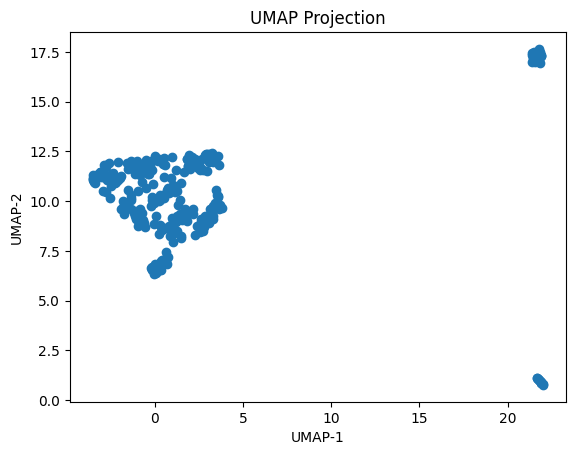

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

# Create a toy dataset (100 samples × 50 features)
X = df.iloc[:, 60:132].values

# Remove columns that has NaN
X = np.nan_to_num(X)
X.shape

# Initialize UMAP
umap_model = UMAP(
    n_neighbors=15,    # how many nearest neighbors to consider
    min_dist=0.1,      # how tightly points are packed
    n_components=2,    # target dimensionality
    random_state=42    # reproducibility
)

# Fit & transform
X_embedded = umap_model.fit_transform(X)
print("Embedded shape:", X_embedded.shape)

# 4️⃣ Visualize
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title("UMAP Projection")
plt.xlabel("UMAP‑1")
plt.ylabel("UMAP‑2")

In [184]:
# cols_width = [col for col in df.columns if ("width" in col and "adapt_ratio" not in col)]
cols_width = ['width_rheo', 'width_short_square', 'efel_AP_duration_half_width @ long_square_rheo, min']

In [14]:
# Find out NaN values
df[cols_width].isna().sum()


width_rheo                                             42
width_short_square                                     50
efel_AP_duration_half_width @ long_square_rheo, min    17
dtype: int64

In [186]:
df["injection region"].unique()

def _format_injection_region(x):
    if x != x:
        return "None"
    if "pl" in x.lower():
        return "Cortex"
    return x
    
df["injection region"] = df["injection region"].apply(_format_injection_region)

In [187]:
df["injection region"].unique()

array(['Non-Retro', 'Crus 1', 'Cortex', 'C5', 'VAL'], dtype=object)

In [188]:
df_width = df[["injection region", "y"] + cols_width].copy()

# Set any value in cols_widths > 10 ms to None
df_width[cols_width] = df_width[cols_width].mask(df_width[cols_width] > 10, None) # in ms

# Specify the desired order
area_order = ["Non-Retro", "C5", "Cortex", "VAL", "Crus 1"]
color_order = ["lightgrey", "pink", "green", "red", "gold"]

# Convert the column to a categorical type with the given order
df_width["injection region"] = pd.Categorical(df_width["injection region"], categories=area_order, ordered=True)

# Sort the DataFrame by the categorical column
df_width = df_width.sort_values("injection region")
df_width.rename(columns={"y": "y (D -> V)"}, inplace=True)


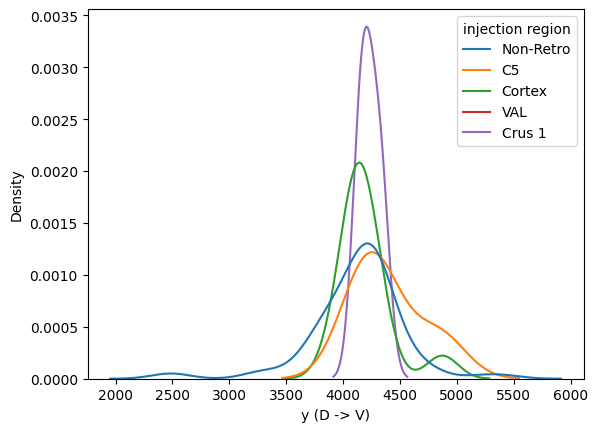

In [189]:
sns.kdeplot(
    data=df_width,
    x="y (D -> V)",
    hue="injection region",
    common_norm=False,
    # kde=True,
    # stat="count",
    # bins=50,
    color="black",
)
plt.show()

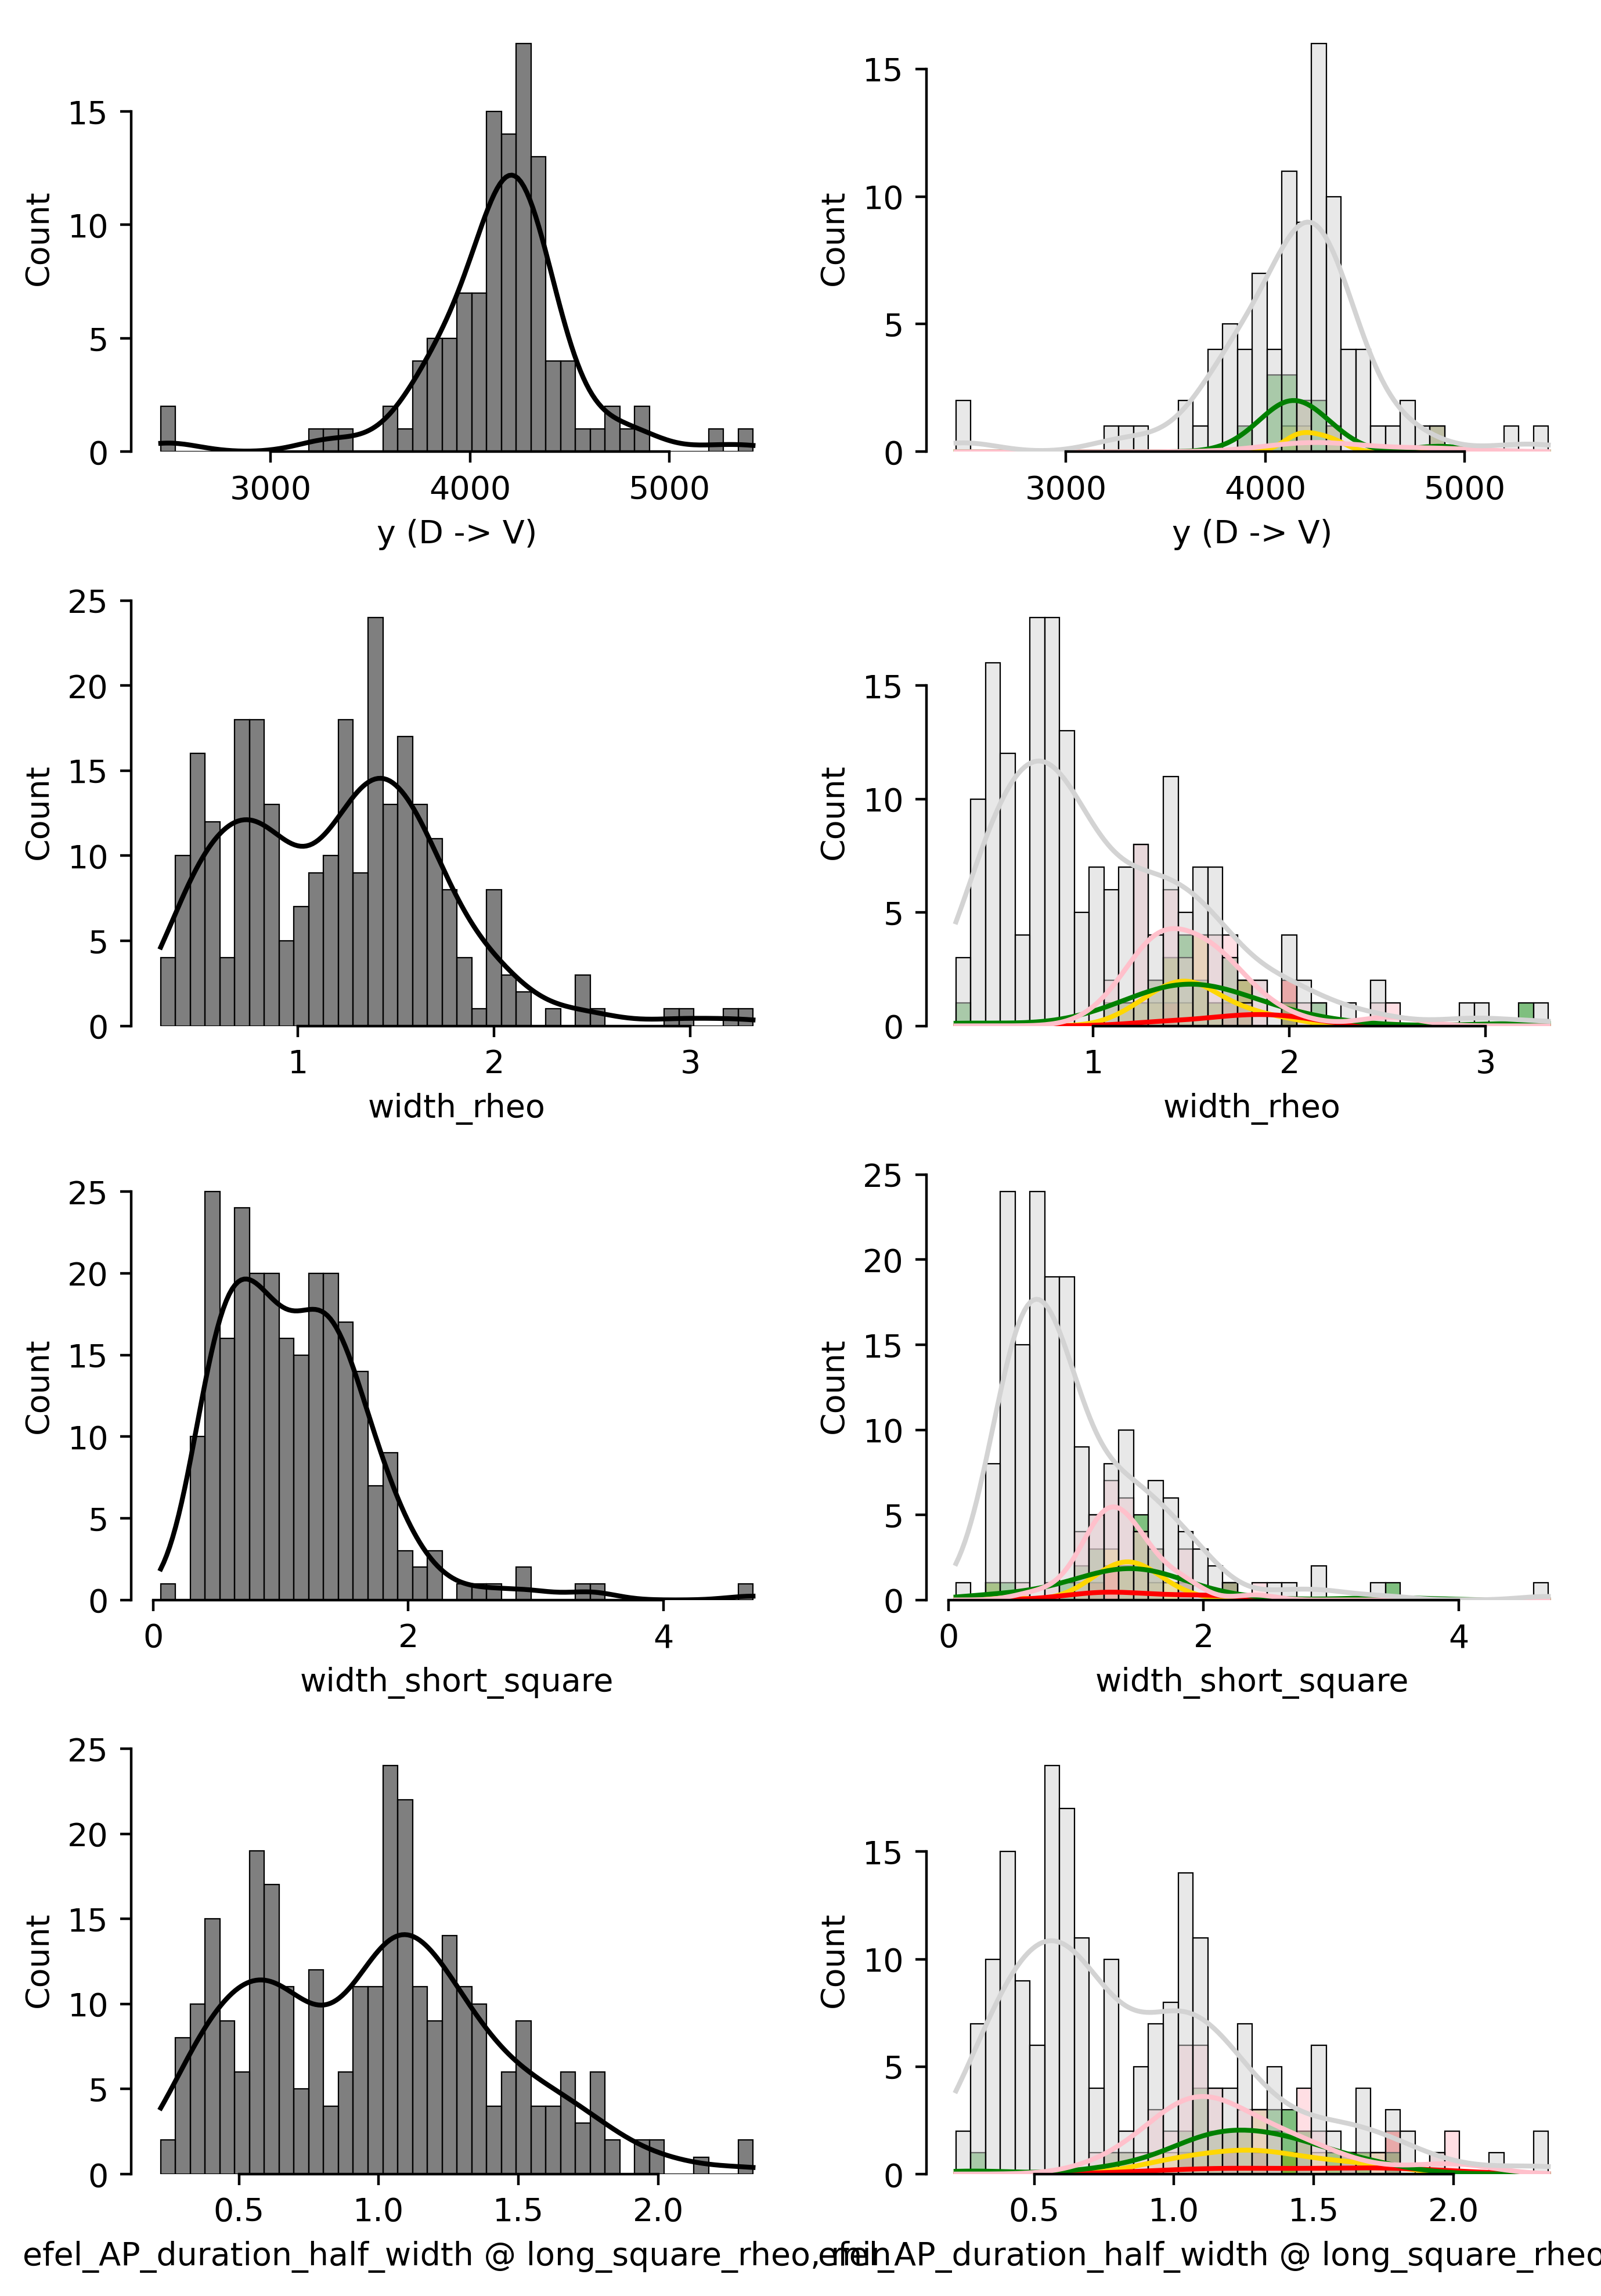

In [193]:
width = ["y (D -> V)"] + [col for col in cols_width if "width" in col]
fig, ax = plt.subplots(len(width), 2, figsize=(7, 10))

for i, x in enumerate(width):
    sns.histplot(
        data=df_width,
        x=x,
        kde=True,
        stat="count",
        bins=40,
        color="black",
        ax=ax[i, 0],
    )
    sns.histplot(
        data=df_width,
        x=x,
        kde=True,
        hue="injection region",
        hue_order=area_order,
        palette=color_order,
        stat="count",
        bins=40,
        ax=ax[i, 1],
        legend=False,
        common_norm=True,
    )

sns.despine(trim=True)
fig.tight_layout()
fig.set_dpi(400)

In [107]:
df.query("`injection region` == 'Cortex' & `first_spike_AP_duration_half_width @ short_square_rheo, aver` < 0.5")["y_tab_master"]

129    4872.313477
Name: y_tab_master, dtype: float64

In [26]:
df.y_tab_master.notna().sum()

np.int64(113)

In [27]:
df_width["y (D -> V)"]

0              NaN
171    4059.010010
172    4252.699707
173            NaN
174            NaN
          ...     
87             NaN
85             NaN
84             NaN
103    4144.880370
86             NaN
Name: y (D -> V), Length: 271, dtype: float64

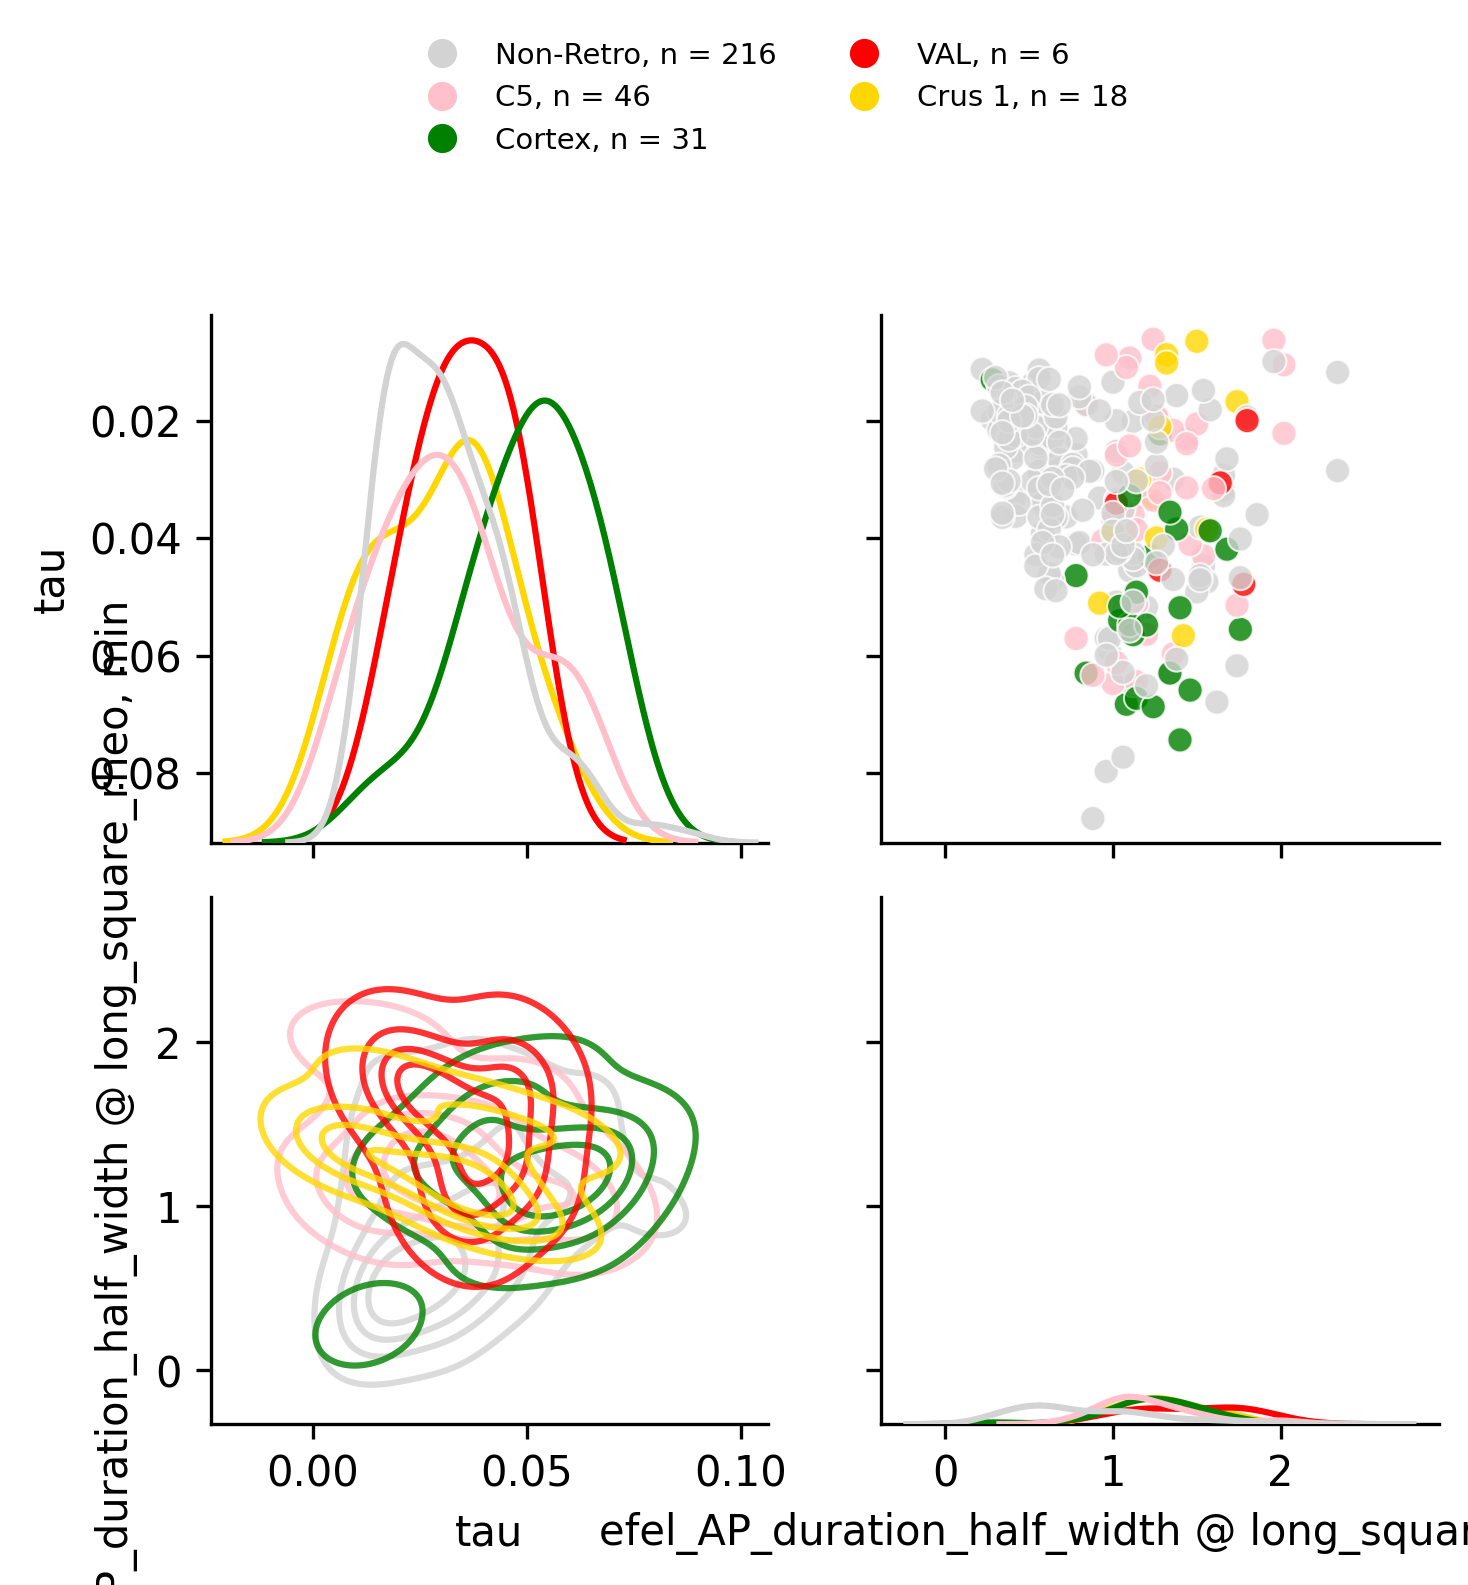

In [204]:
import matplotlib.pyplot as plt


def plot_pair_grid(df, area_order, color_order):
    g = sns.PairGrid(
        df_to_pair,
        hue="injection region",
        hue_order=area_order,
        palette=color_order,
    )

    # Add a diagnoal line
    axes = g.axes
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            if i != j and i > 0 and j > 0:
                axes[i, j].plot([0, 3], [0, 3], '--k')
                # axes[i, j].set_xlim(0, 5)
                # axes[i, j].set_ylim(0, 5)
            if i == 0 and j == 0:
                # invert y axis
                axes[i, j].invert_yaxis()


    g.map_upper(sns.scatterplot, alpha=0.8)
    g.map_lower(sns.kdeplot, fill=False, alpha=0.8, common_norm=False, levels=5)
    g.map_diag(sns.kdeplot, common_norm=False, legend=True)

    g.fig.set_dpi(300)            

    # Create legend handles manually.
    handles = [
        plt.Line2D(
            [],
            [],
            marker="o",
            linestyle="",
            color=color,
            label=f"{area}, n = {len(df_to_pair[df_to_pair['injection region'] == area])}",
        )
        for area, color in zip(
            area_order,
            color_order,
        )
    ]

    # Add the legend to the selected diagonal axis.
    g.fig.legend(handles=handles, loc="upper center", fontsize=7, bbox_to_anchor=(0.5, 1.05), frameon=False, ncol=2)
    g.fig.subplots_adjust(top=0.85)  # Adjust top margin to make room for legend

df_to_pair = df_meta[["injection region", "tau", "efel_AP_duration_half_width @ long_square_rheo, min"]]
plot_pair_grid(df_to_pair, area_order, color_order)

Show overlaid extracted waveforms

In [5]:
df_cell_representative_spike_waveforms = pd.read_pickle("/Users/han.hou/Scripts/LCNE-patchseq-analysis/results/cell_stats/cell_level_spike_waveforms.pkl")

In [87]:
# Get index names
df_cell_representative_spike_waveforms.index.get_level_values(1).unique()

Index(['short_square_rheo, min', 'short_square_rheo, aver',
       'long_square_rheo, min', 'long_square_rheo, aver', 'subthreshold, 90',
       'subthreshold, aver', 'long_square_supra, min',
       'long_square_supra, aver', 'subthreshold, 50'],
      dtype='object', name='extract_from')

In [25]:
def _normalize(x, idx_range_to_norm=None):
    x0 = x if idx_range_to_norm is None else x[:, idx_range_to_norm]
    min_vals = np.min(x0, axis=1, keepdims=True)
    range_vals = np.ptp(x0, axis=1, keepdims=True)
    return (x - min_vals) / range_vals


def extract_representative_spikes(df, 
                                        extract_from,
                                        if_normalize_v: bool = True, 
                                        normalize_window_v: tuple = (-2, 4), 
                                        if_normalize_dvdt: bool = True,
                                        normalize_window_dvdt: tuple = (-2, 0),
                                        if_smooth_dvdt: bool = True,
                                        ):
    # Get the waveforms
    df_waveforms = df.query("extract_from == @extract_from")

    t = df_waveforms.columns.values.T
    v = df_waveforms.values
    dvdt = np.gradient(v, t, axis=1)
    
    # Normalize the dvdt
    if if_normalize_dvdt:
        dvdt = _normalize(dvdt, idx_range_to_norm=
                          np.where((t >= normalize_window_dvdt[0]) & (t <= normalize_window_dvdt[1]))[0])
        
    if if_smooth_dvdt:
        from scipy.signal import savgol_filter
        dvdt = savgol_filter(dvdt, window_length=5, polyorder=3, axis=1)
    
    dvdt_max_idx = np.argmax(dvdt, axis=1)
    max_shift_right = dvdt_max_idx.max() - dvdt_max_idx.min()

    # Calculate new time array that spans all possible shifts, with time 0 at alignment point
    dt = t[1] - t[0]
    t_dvdt = -dvdt_max_idx.max() * dt + np.arange(len(t) + max_shift_right) * dt

    # Create new dvdt array with NaN padding
    new_dvdt = np.full((dvdt.shape[0], len(t_dvdt)), np.nan)

    # For each cell, place its dvdt trace in the correct position
    for i, (row, peak_idx) in enumerate(zip(dvdt, dvdt_max_idx)):
        # Calculate where this trace should start in the new array
        start_idx = dvdt_max_idx.max() - peak_idx  # Align the max_index
        # Place the trace in the new array
        new_dvdt[i, start_idx:start_idx + len(row)] = row
    
    # Normalize the v
    if if_normalize_v:
        idx_range_to_norm = np.where((t >= normalize_window_v[0]) & (t <= normalize_window_v[1]))[0]
        v = _normalize(v, idx_range_to_norm)
        
    return t, v, new_dvdt, t_dvdt

t, v, dvdt, t_dvdt = extract_representative_spikes(df_cell_representative_spike_waveforms,
                                    extract_from="long_square_rheo, min",
                                    if_normalize_v=True,
                                    normalize_window_v=(-2, 4),
                                    if_normalize_dvdt=True,
                                    normalize_window_dvdt=(-2, 0),
                                    if_smooth_dvdt=False,
                                    )

In [19]:
v.shape

(255, 750)

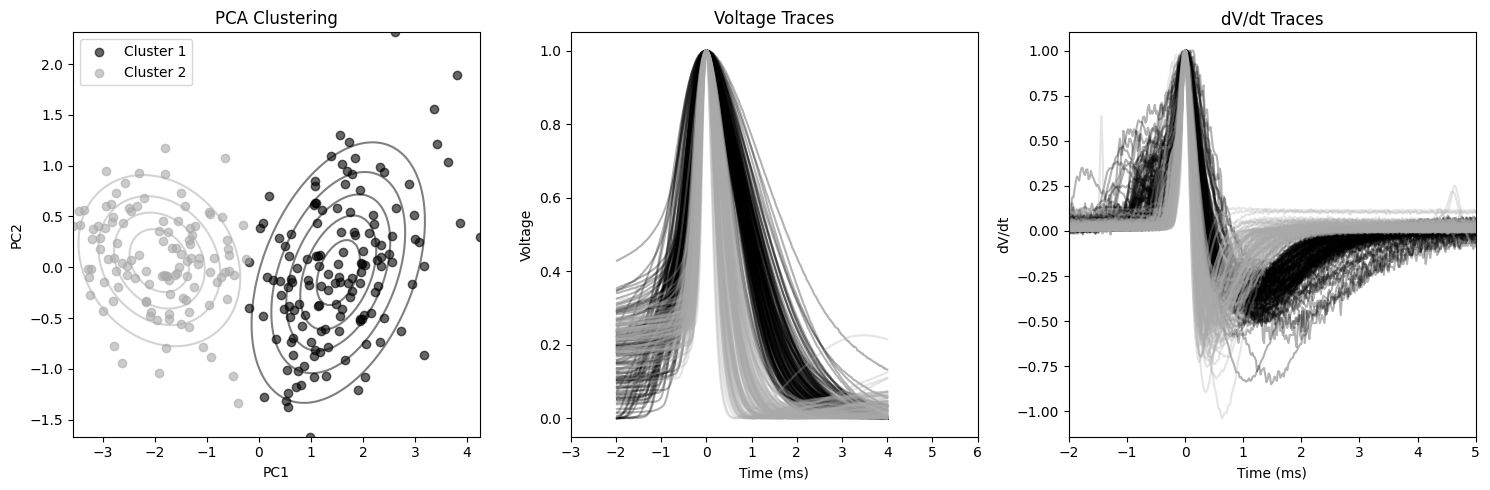

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline

# Perform PCA
pca = PCA(n_components=10)

v = v[:, np.where((t >= -2) & (t <= 5))[0]]
t = t[np.where((t >= -2) & (t <= 5))[0]]
pca.fit(v)
v_pca = pca.transform(v)

# K-means clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(v_pca[:, :2])

colors = ['black', 'darkgray', 'red', 'green', 'blue'][:n_clusters]

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot PCA scatter with contours
for i in range(n_clusters):
    mask = clusters == i
    
    # Scatter plot
    ax1.scatter(v_pca[mask, 0], v_pca[mask, 1], c=colors[i], alpha=0.6, label=f'Cluster {i+1}')
    
    # Add contours
    mean = np.mean(v_pca[mask, :2], axis=0)
    cov = np.cov(v_pca[mask, :2].T)
    x, y = np.mgrid[v_pca[:,0].min():v_pca[:,0].max():100j,
                    v_pca[:,1].min():v_pca[:,1].max():100j]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    z = rv.pdf(pos)
    ax1.contour(x, y, z, levels=5, colors=colors[i], alpha=0.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2') 
ax1.set_title('PCA Clustering')
ax1.legend()

# Plot voltage traces
for i in range(n_clusters):
    mask = clusters == i
    for trace in v[mask]:
        ax2.plot(t, trace, c=colors[i], alpha=0.3)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage')
ax2.set_title('Voltage Traces')
ax2.set_xlim(-3, 6)

# Plot dV/dt traces  
for i in range(n_clusters):
    mask = clusters == i
    for trace in dvdt[mask]:
        ax3.plot(t_dvdt, trace, c=colors[i], alpha=0.3)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('dV/dt')
ax3.set_title('dV/dt Traces')
ax3.set_xlim(-2, 5)

plt.tight_layout()
plt.show()

/Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


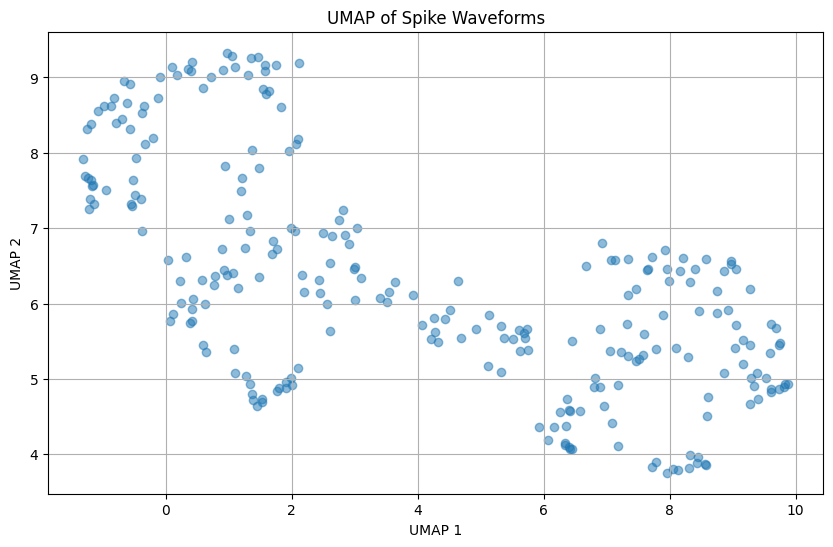

In [ ]:
import umap


# Run UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
spike_umap = umap_model.fit_transform(v)

# Plot UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(spike_umap[:, 0], spike_umap[:, 1], alpha=0.5)
plt.title('UMAP of Spike Waveforms')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid()
plt.show()


In [229]:
from LCNE_patchseq_analysis.data_util.metadata import load_ephys_metadata
df_meta = load_ephys_metadata(if_from_s3=True)
df_meta.shape

(317, 301)

In [155]:
valid_n = pd.DataFrame(df_meta.notna().sum())
valid_n["unique_values"] = df_meta.apply(lambda x: x.unique())
valid_n.to_csv("./valid_n.csv")

In [286]:
X_cols = [
    "ephys_roi_id",
    "injection region",
    "x",
    "y",
    "z",
]
ipfx_cols = [
    "electrode_0_pa_qc",
    "seal_gohm_qc",
    "input_resistance_mohm_qc",
    "initial_access_resistance_mohm_qc",
    "input_access_resistance_ratio_qc",
    "sag",
    "sag_area",
    "v_baseline",
    "rheobase_i",
    "fi_fit_slope",
    "vm_for_sag",
    "input_resistance",
    "input_resistance_ss",
    "latency_rheo",
    "avg_rate_rheo",
    "threshold_v_rheo",
    "peak_v_rheo",
    "upstroke_rheo",
    "avg_rate_hero",
    "latency_hero",
    "threshold_v_hero",
    "peak_v_hero",
    "upstroke_hero",
    "avg_rate_max",
    "peak_deltav_rheo",
    "peak_deltav_hero",
    "tau",
    "upstroke_downstroke_ratio_rheo",
    "width_rheo",
    "downstroke_rheo",
    "width_suprathresh_rheo",
    "trough_v_rheo",
    "fast_trough_v_rheo",
    "postap_slope_rheo",
    "trough_slowdeltav_rheo",
    "fast_trough_deltav_rheo",
    "upstroke_downstroke_ratio_hero",
    "width_hero",
    "downstroke_hero",
    "width_suprathresh_hero",
    "trough_v_hero",
    "fast_trough_v_hero",
    "postap_slope_hero",
    "trough_slowdeltav_hero",
    "fast_trough_deltav_hero",
    "fast_trough_v_last_rheo",
    "isi_cv_mean",
    "adapt_mean",
    "upstroke_downstroke_ratio_short_square",
    "threshold_v_short_square",
    "upstroke_short_square",
    "downstroke_short_square",
    "peak_deltav_short_square",
    "width_short_square",
    "sag_depol",
    "sag_area_depol",
    "width_suprathresh_short_square",
    "mean_isi_hero",
    "median_isi_hero",
    "isi_cv_hero",
    "ahp_delay_ratio_hero",
    "first_isi_inv_hero",
    "isi_adapt_ratio",
    "width_adapt_ratio",
    "upstroke_adapt_ratio",
    "downstroke_adapt_ratio",
    "threshold_v_adapt_ratio",
    "ahp_delay_ratio_5spike",
    "peak_v_adapt_ratio",
    "adapt_hero",
    "ir_late_mean",
]

Efel_cols = [col for col in df_meta.columns if "efel" in col]

Y_cols = ipfx_cols + Efel_cols

# Convert categorical injection region to numerical values using one-hot encoding
df = df_meta[X_cols + Y_cols]
df = pd.get_dummies(df, columns=['injection region'])

# Update x_cols
X_cols = [col for col in df.columns if col not in ipfx_cols + Efel_cols]
df 

,ephys_roi_id,x,y,z,electrode_0_pa_qc,seal_gohm_qc,input_resistance_mohm_qc,initial_access_resistance_mohm_qc,input_access_resistance_ratio_qc,sag,...,"efel_sag_time_constant @ subthreshold, 90","efel_sag_amplitude @ subthreshold, aver","efel_sag_ratio1 @ subthreshold, aver","efel_sag_ratio2 @ subthreshold, aver","efel_sag_time_constant @ subthreshold, aver",injection region_C5,injection region_Cortex,injection region_Crus 1,injection region_Non-Retro,injection region_VAL
0,1428462010,NaN,NaN,NaN,13.310625,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False
1,1428452587,NaN,NaN,NaN,15.075000,1.521846,263.867984,16.753659,0.063493,0.093257,...,35.937907,5.334070,0.204908,0.795092,11.589950,False,False,False,True,False
2,1428435753,NaN,NaN,NaN,28.405001,3.607978,225.631536,9.484417,0.042035,0.017171,...,5.248385,0.719179,0.037855,0.962145,14.709858,False,False,False,True,False
3,1428429693,NaN,NaN,NaN,16.399376,3.214522,339.174048,8.066693,0.023783,0.017922,...,148.639918,0.594175,0.025480,0.974520,85.750726,False,False,False,True,False
4,1428323001,NaN,NaN,NaN,2.328750,4.405880,417.240288,12.170877,0.029170,0.133667,...,167.757148,6.150634,0.154663,0.845337,184.361840,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,1212557784,NaN,NaN,NaN,3.867500,2.680084,295.735392,17.407112,0.058860,NaN,...,51.668994,10.078559,0.487712,0.512288,55.538646,False,False,False,True,False
313,1212546732,NaN,NaN,NaN,-4.151250,1.797682,283.806048,10.253576,0.036129,NaN,...,59.080220,6.087284,0.356014,0.643986,118.795060,False,False,False,True,False
314,1212572517,NaN,NaN,NaN,-10.383125,5.130808,417.480032,10.274573,0.024611,NaN,...,139.301133,9.914407,0.284532,0.715468,150.572087,False,False,False,True,False
315,1212579992,NaN,NaN,NaN,-7.022500,4.345140,596.878016,8.886913,0.014889,0.217389,...,714.573754,4.294960,0.156985,0.843015,313.359286,False,False,False,True,False


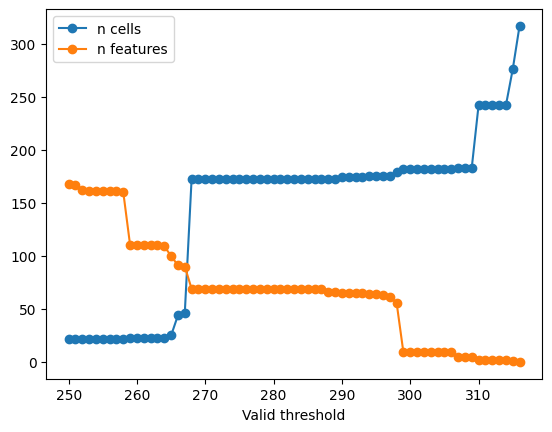

In [287]:
# Threshold for valid columns
thresholds = range(250, len(df_meta), 1)
shapes_list = []
for valid_threshold in thresholds:
    ipfx_cols_filtered = [col for col in ipfx_cols if valid_n.loc[col][0] > valid_threshold]
    Efel_cols_filtered = [col for col in Efel_cols if valid_n.loc[col][0] > valid_threshold]

    Y_cols_filtered = ipfx_cols_filtered + Efel_cols_filtered

    # Remove nan values
    df_Y = df_meta[Y_cols_filtered].dropna(axis=0)
    shapes_list.append(df_Y.shape)

plt.plot(thresholds, [shape[0] for shape in shapes_list], label="n cells", marker="o")
plt.plot(thresholds, [shape[1] for shape in shapes_list], label="n features", marker="o")
plt.xlabel("Valid threshold")
plt.legend()
plt.show()

from sklearn.linear_model import LinearRegression
from scipy import stats

# Initialize lists to store results
p_values = []
r2_scores = []
feature_names = []


In [205]:
# Run linear regression for each Y column
for y_col in Y_cols_filtered[:10]:
    # Prepare data
    x = df[X_cols]
    y = df_meta[y_col].values
    
    # Remove rows with NaN values
    mask = ~np.isnan(y) & ~np.isnan(x).any(axis=1)
    X = x[mask]
    y = y[mask]
    
    if len(y) > 0:  # Only proceed if we have valid data
        # Fit linear regression
        reg = LinearRegression()
        reg.fit(X, y)
        
        # Calculate R^2
        r2 = reg.score(X, y)
        
        # Calculate p-values
        n = X.shape[0]
        p = X.shape[1]
        dof = n - p - 1
        t_stat = reg.coef_ / np.sqrt(np.sum((y - reg.predict(X))**2) / dof / np.sum((X - X.mean(axis=0))**2, axis=0))
        p_val = 2 * (1 - stats.t.cdf(np.abs(t_stat), dof))
        
        # Store results
        p_values.append(p_val)
        r2_scores.append(r2)
        feature_names.append(y_col)

# Create a DataFrame to display results
results_df = pd.DataFrame({
    'Feature': feature_names,
    'R^2': r2_scores,
    'P-value': p_values
})

# Display results
results_df


KeyError: "['injection region_C5', 'injection region_Cortex', 'injection region_Crus 1', 'injection region_Non-Retro', 'injection region_VAL'] not in index"

In [256]:
best_threshold = 270
ipfx_cols_filtered = [col for col in ipfx_cols if valid_n.loc[col][0] > best_threshold]
Efel_cols_filtered = [col for col in Efel_cols if valid_n.loc[col][0] > best_threshold]

Y_cols_filtered = ipfx_cols_filtered + Efel_cols_filtered
df_Y = df_meta[["ephys_roi_id", "injection region"] + Y_cols_filtered].dropna(axis=0)
df_Y.shape

(189, 71)

In [289]:
Y_cols_filtered = ["efel_AP_duration_half_width @ long_square_rheo, min", "tau", "input_resistance_ss"]
df_Y = df_meta[["ephys_roi_id", "injection region"] + Y_cols_filtered].dropna(axis=0)
df_Y.shape

(204, 5)

<Axes: >

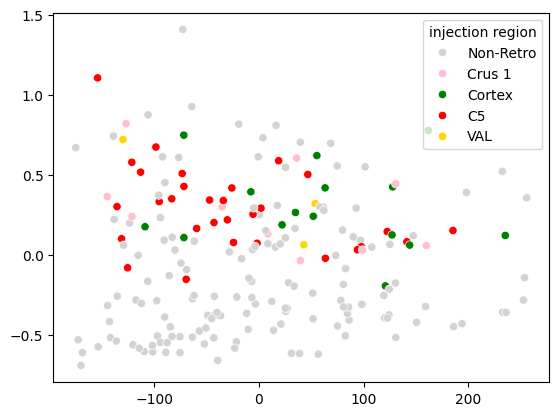

In [290]:
# Perform PCA on df_Y's Y_cols_filtered
pca = PCA(n_components=2)
pca.fit(df_Y[Y_cols_filtered])
df_Y_pca = pca.transform(df_Y[Y_cols_filtered])
df_Y_pca
# Plot PCA
sns.scatterplot(data=df_Y, x=df_Y_pca[:, 0], y=df_Y_pca[:, 1], hue="injection region", palette=color_order)

/Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

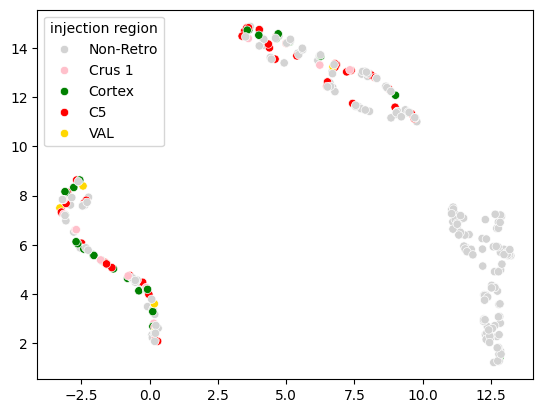

In [275]:
# Perform UMAP on df_Y's Y_cols_filtered
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
df_Y_umap = umap_model.fit_transform(df_Y[Y_cols_filtered])
# Plot UMAP
sns.scatterplot(data=df_Y, x=df_Y_umap[:, 0], y=df_Y_umap[:, 1], hue="injection region", palette=color_order)


In [ ]:
df_meta = load_ephys_metadata(if_from_s3=True)

# Calculate number of rows needed (2 rows per feature)
n_features = len(Y_cols)
n_rows = (n_features + 1) // 2  # Round up division

# Create figure with subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3*n_rows), dpi=300,
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
axes = axes.flatten()

# Set any value outside 5 std to NaN for each column in Y_cols
for col in Y_cols:
    df_meta[col] = df_meta[col].mask(np.abs(df_meta[col]) > 5 * df_meta[col].std())

# Plot histograms for each feature
for i, col in enumerate(sorted(Y_cols)):
    try:
        # Main histogram plot
        sns.histplot(data=df_meta, ax=axes[i], kde=True, x=col, bins=30,
                    hue="injection region", hue_order=area_order, palette=color_order, legend=False)
        if '@' in col:
            axes[i].set_xlabel("\n@ ".join(line for line in col.split('@')))
        else:
            axes[i].set_xlabel(col)
            
        # Add number of notna values in the legend for each hue
        n_notna = df_meta.groupby("injection region")[col].count()
        axes[i].legend(labels=[f"{area} = {n_notna.loc[area]}" for area in area_order], 
                    handlelength=0,
                    loc="upper left", fontsize=5,
                    frameon=False,
                    )

        # Create inset for KDE
        ax_inset = axes[i].inset_axes([0.6, 0.6, 0.35, 0.35])
        sns.kdeplot(data=df_meta, ax=ax_inset, x=col, hue="injection region",
                    hue_order=area_order, palette=color_order, common_norm=False, legend=False)
        ax_inset.yaxis.set_visible(False)
        ax_inset.set_xlabel('')
        ax_inset.set_xticks([])
        # transpancy of ax_inset
        ax_inset.patch.set_alpha(0.5)
        sns.despine(ax=ax_inset, left=True, top=True, right=True)
    except:
        pass

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

sns.despine()
# plt.tight_layout()
plt.show()